In [142]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy
import scipy.stats as stats
import sklearn.impute as simpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,PolynomialFeatures,QuantileTransformer
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import plotly.express as px

import acquire
import acq
import wrangle_zillow
import wrangle_mall
import explore_zillow
import env

# Acquire data from the customers table in the mall_customers database

In [143]:
df = acq.get_mallcustomer_data()


In [144]:
num_missing = df.isnull().sum(axis=1)
prnt_miss = num_missing / df.shape[1] * 100
rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 'percent_cols_missing': prnt_miss})\
.reset_index().groupby(['num_cols_missing', 'percent_cols_missing']).count().reset_index()

In [145]:
rows_missing.columns[-1]

'customer_id'

In [146]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None


# Summarize the data (include distributions and descriptive statistics).

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB

	nulls by column
 gender            0
age               0
annual_income     0
spending_score    0
dtype: int64


,age,annual_income,spending_score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


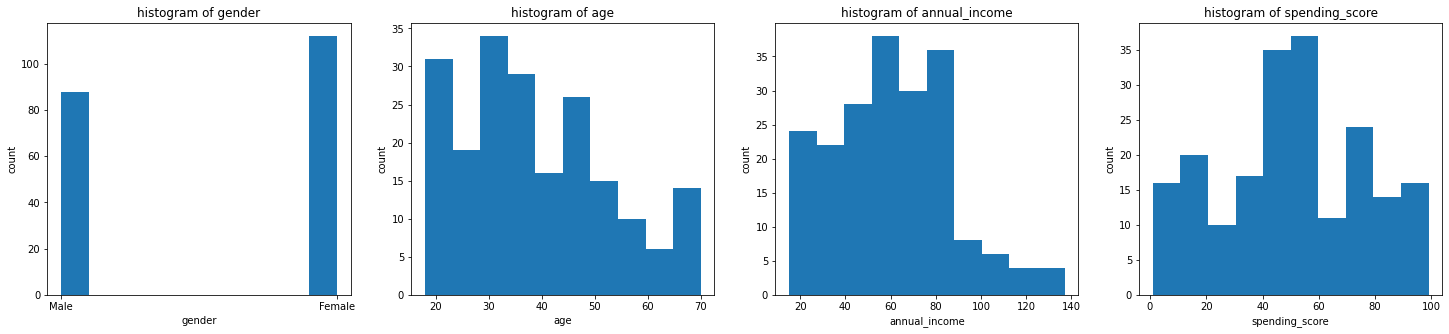

In [147]:
df.info()
#df.value_counts().to_frame()
plt.figure(figsize=(25, 5))
for i, col in enumerate(df.columns.tolist()): # List of columns
    plot_number = i + 1 # i starts at 0, but plot nos should start at 1
    plt.subplot(1,len(df.columns.tolist()), plot_number) # Create subplot.
    plt.title(f"histogram of {col}") # Title with column name.
    plt.xlabel(col)
    plt.ylabel("count")
    df[col].hist(bins=10) # Display histogram for column.
    plt.grid(False) # Hide gridlines.

print("\n\tnulls by column\n", df.isna().sum())
df.describe()


In [148]:
num_missing = df.isna().sum().sum()
prnt_miss = num_missing / (df.shape[1]*df.shape[0]) * 100
prnt_miss, "%"

(0.0, '%')

# Detect outliers using IQR

In [149]:
def get_outliers(df, k):
   '''
    Given a series and a cutoff value, k (tukey value), returns the upper outliers for the series.
    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound (q3 + (k*iqr)) the observation is.
   '''
   for col in df.describe().columns:
      if not col.endswith('_outlier'):
         q1, q3 = df[col].quantile([.25, .75])
         iqr = q3 - q1
         upper_bound = q3 + k * iqr
         lower_bound = q1 - k * iqr
         #print(col)
         df[f"{col}_outlier"] = np.where((df[col] - upper_bound) > 0,(df[col] - upper_bound),
                                       np.where((df[col] - lower_bound)<0,(df[col] - lower_bound),0))

   outlier_cols = [col for col in df if col.endswith('_outlier')]
   for col in outlier_cols:
      print('~~~\n' + col)
      data = df[col][df[col] > 0]
      print(data.describe())
   return df,outlier_cols

In [150]:
df_temp,_ = get_outliers(df,1.5)

df_temp

~~~
age_outlier
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age_outlier, dtype: float64
~~~
annual_income_outlier
count    2.00
mean     4.25
std      0.00
min      4.25
25%      4.25
50%      4.25
75%      4.25
max      4.25
Name: annual_income_outlier, dtype: float64
~~~
spending_score_outlier
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: spending_score_outlier, dtype: float64


,gender,age,annual_income,spending_score,age_outlier,annual_income_outlier,spending_score_outlier
customer_id,,,,,,,
1,Male,19,15,39,0.0,0.00,0.0
2,Male,21,15,81,0.0,0.00,0.0
3,Female,20,16,6,0.0,0.00,0.0
4,Female,23,16,77,0.0,0.00,0.0
5,Female,31,17,40,0.0,0.00,0.0
...,...,...,...,...,...,...,...
196,Female,35,120,79,0.0,0.00,0.0
197,Female,45,126,28,0.0,0.00,0.0
198,Male,32,126,74,0.0,0.00,0.0


# Encode categorical columns using a one hot encoder (pd.get_dummies).

In [151]:
for col in df.select_dtypes(include=['object']).columns:
    df = pd.concat([df,pd.get_dummies(df[col],drop_first=True)],axis=1)
    df.drop(columns=col,inplace=True)
df

,age,annual_income,spending_score,age_outlier,annual_income_outlier,spending_score_outlier,Male
customer_id,,,,,,,
1,19,15,39,0.0,0.00,0.0,1
2,21,15,81,0.0,0.00,0.0,1
3,20,16,6,0.0,0.00,0.0,0
4,23,16,77,0.0,0.00,0.0,0
5,31,17,40,0.0,0.00,0.0,0
...,...,...,...,...,...,...,...
196,35,120,79,0.0,0.00,0.0,0
197,45,126,28,0.0,0.00,0.0,0
198,32,126,74,0.0,0.00,0.0,1


# Split data into train, validate, and test.

In [152]:
# Create train_validate and test datasets
train_validate, test = train_test_split(df, test_size=0.2, random_state=123)
# Create train and validate datsets
train, validate = train_test_split(train_validate, test_size=0.25, random_state=123)

print(f"train -> {train.shape}")
print(f"validate -> {validate.shape}")
print(f"test -> {test.shape}")

target = "spending_score"

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train.drop(columns=[target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate.drop(columns=[target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test.drop(columns=[target])
y_test = test[target]



train -> (120, 7)
validate -> (40, 7)
test -> (40, 7)


# Handles missing values.

In [153]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .75):
    threshold = int(round(prop_required_column*len(df.index),0))
    df.dropna(axis=1, thresh=threshold, inplace=True)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

def data_prep(df, cols_to_remove=[], prop_required_column=.5, prop_required_row=.75):
    df = df.drop(columns=cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

In [154]:
data_prep(df)

,age,annual_income,spending_score,age_outlier,annual_income_outlier,spending_score_outlier,Male
customer_id,,,,,,,
1,19,15,39,0.0,0.00,0.0,1
2,21,15,81,0.0,0.00,0.0,1
3,20,16,6,0.0,0.00,0.0,0
4,23,16,77,0.0,0.00,0.0,0
5,31,17,40,0.0,0.00,0.0,0
...,...,...,...,...,...,...,...
196,35,120,79,0.0,0.00,0.0,0
197,45,126,28,0.0,0.00,0.0,0
198,32,126,74,0.0,0.00,0.0,1


In [155]:
train.head(1)

,age,annual_income,spending_score,age_outlier,annual_income_outlier,spending_score_outlier,Male
customer_id,,,,,,,
64,54,47,59,0.0,0.0,0.0,0


DataFrame head: 

             gender  age  annual_income  spending_score
customer_id                                            
1              Male   19             15              39
2              Male   21             15              81
3            Female   20             16               6
4            Female   23             16              77
5            Female   31             17              40
----------
DataFrame info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None
----------
Dataframe Description: 

              age  annual_income  spending_score
count  200.000000     200.000000      200.000000
mean

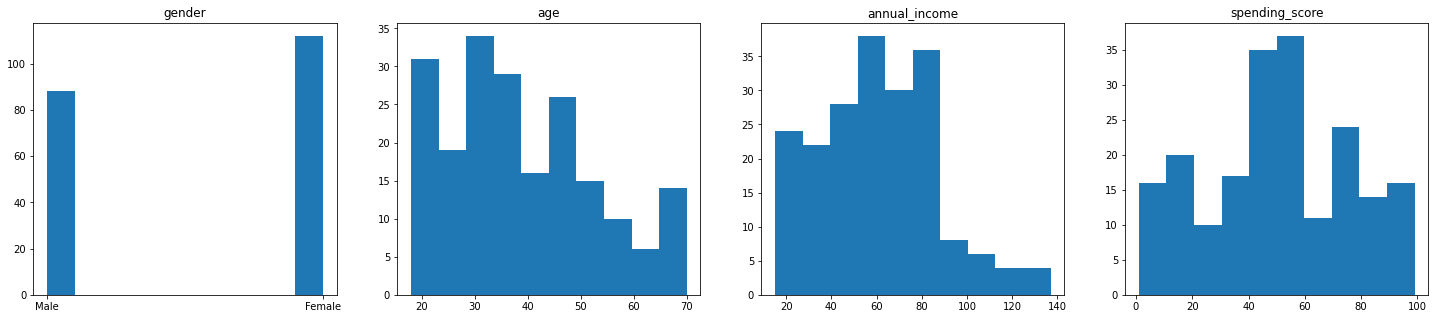

In [156]:
df, mod_df, df_outlier, cols_missing, rows_missing, outlier_cols,X_train, y_train, \
                X_validate, y_validate,  X_test, y_test, train, validate, \
                test,X_train_scaled, X_validate_scaled, X_test_scale = wrangle_mall.wrangle_mall()

# Scaling

In [157]:
#scale_cols = train.drop(columns=target).select_dtypes(["int64"]).columns.tolist()
scale_cols = ["age","annual_income"]


scaler = MinMaxScaler(copy=True).fit(X_train[scale_cols])

# scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train.
#
X_train_scaled_array = scaler.transform(X_train[scale_cols])
X_validate_scaled_array = scaler.transform(X_validate[scale_cols])
X_test_scaled_array = scaler.transform(X_test[scale_cols])

# convert arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=scale_cols).set_index([X_train.index.values])

X_validate_scaled = pd.DataFrame(X_validate_scaled_array, columns=scale_cols).set_index([X_validate.index.values])

X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=scale_cols).set_index([X_test.index.values])

# Explore

In [158]:
train

,age,annual_income,spending_score,Male
customer_id,,,,
64,54,47,59,0
49,29,40,42,0
25,54,28,14,0
137,44,73,7,0
177,58,88,15,1
...,...,...,...,...
176,30,88,86,0
102,49,62,48,0
149,34,78,22,0


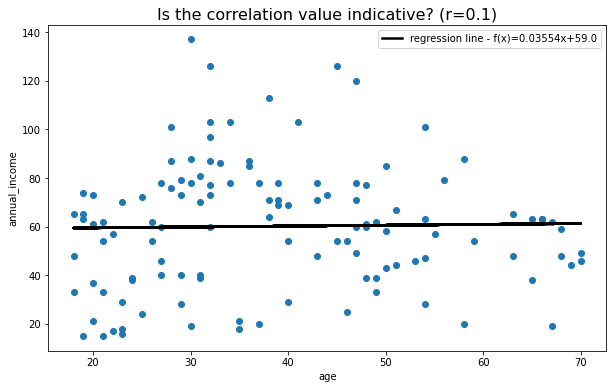

r = 0.05416502323241103

 We fail to reject the null hypothesis ( That the distributions underlying the samples of age and annual_income are unrelated ) p=0.55682


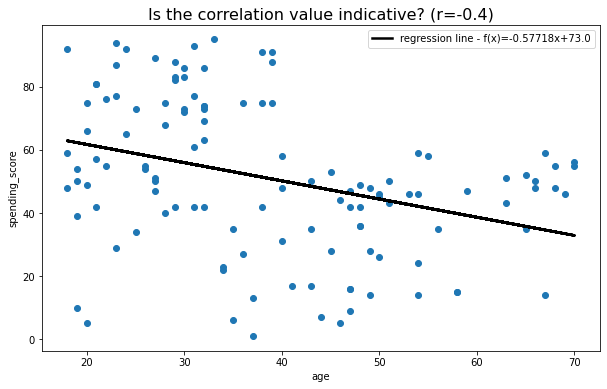

r = -0.3675786602565466

 We reject the null Hypothesis ( T̶h̶a̶t̶ ̶t̶h̶e̶ ̶d̶i̶s̶t̶r̶i̶b̶u̶t̶i̶o̶n̶s̶ ̶u̶n̶d̶e̶r̶l̶y̶i̶n̶g̶ ̶t̶h̶e̶ ̶s̶a̶m̶p̶l̶e̶s̶ ̶o̶f̶ ̶a̶g̶e̶ ̶a̶n̶d̶ ̶s̶p̶e̶n̶d̶i̶n̶g̶_̶s̶c̶o̶r̶e̶ ̶a̶r̶e̶ ̶u̶n̶r̶e̶l̶a̶t̶e̶d̶ ) p=0.00004


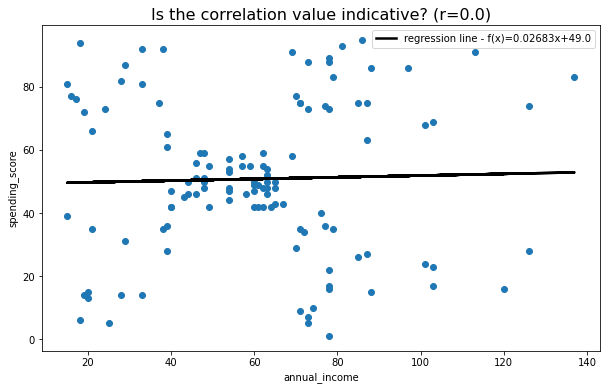

r = 0.01098748360049271

 We fail to reject the null hypothesis ( That the distributions underlying the samples of annual_income and spending_score are unrelated ) p=0.90519


In [159]:
num_vars = ["age","annual_income","spending_score"]

for num2 in num_vars:
    for num1 in num_vars:
        if not num_vars.index(num1) >= num_vars.index(num2):

            H0 = f"That the distributions underlying the samples of {num1} and {num2} are unrelated"
            Ha = f"That the distributions underlying the samples of {num2} and {num2} are related"
            alpha = .05
            r, p = stats.spearmanr(train[num1],train[num2])
            plt.figure(figsize=(10,6))
            plt.scatter( train[num1], train[num2])
            m, b = np.polyfit(train[num1], train[num2], deg=1)
            plt.plot(train[num1], b + m * train[num1], color="k", lw=2.5,label=f"regression line - f(x)={round(m,5)}x+{round(b,0)}")
            plt.xlabel(num1)
            plt.ylabel(num2)
            plt.title(f'Is the correlation value indicative? (r={round(r,1)})', size=16)
            plt.legend()
            plt.show()
            print('r =', r)
            if p > alpha:
                print("\n We fail to reject the null hypothesis (",(H0) , ")",'p=%.5f' % (p))
            else:
                print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")", 'p=%.5f' % (p))

does gender matter to spending score?

-----------------------------
we can accept that there are equal variance in these two groups with 0.74 certainty Flag=T stat=0.10929, p=0.74155

 We fail to reject the null hypothesis ( spending_score of Male1 has identical average values to spending_score of other Male0 ) t=0.24251, p=0.80881


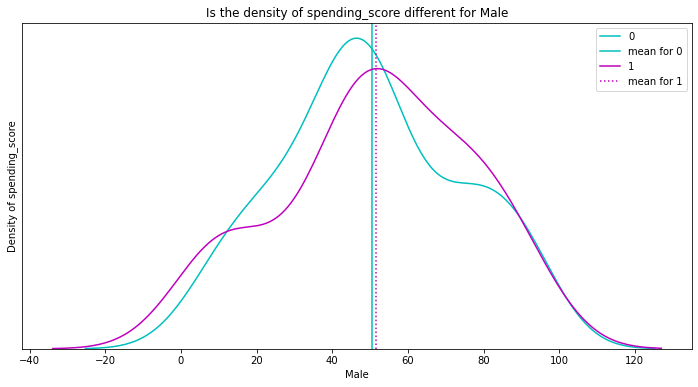

In [160]:

cat = "Male"
num = "spending_score"

alpha = .05
for cat_1 in train[cat].unique():
    for cat_2 in train[cat].unique():
        if not train[cat].unique().tolist().index(cat_2) >= train[cat].unique().tolist().index(cat_1):
            H0 = f"{num} of {cat}{cat_1} has identical average values to {num} of other {cat}{cat_2}"
            Ha = f"{num} of {cat} is not equal to {num} of other {cat}"
            print("-----------------------------")
            #compare variances to know how to run the test
            stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
            stat,pval
            if pval > 0.05:
                equal_var_flag = True
                print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
            else:
                equal_var_flag = False
                print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))
            t, p = stats.ttest_ind( train[train[cat] == cat_1][num], train[train[cat] == cat_2][num], equal_var = equal_var_flag )
            if p > alpha:
                print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
            else:
                print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))
plt.figure(figsize=(12,6))
plt.title(f"Is the density of {num} different for {cat}")
plt.ylabel(f"Density of {num}")
plt.yticks([],[])
colorlist=['c', 'm', 'y', 'k']
linestyle_list = ['solid', 'dotted','dashed','dashdot']
for i in enumerate(train[cat].unique()):
    sns.kdeplot(train[train[cat] == i[1]][num],
                label=f"{i[1]}",
                color=colorlist[i[0]])
    plt.axvline(train[train[cat] == i[1]][num].mean(),
                color=colorlist[i[0]],
                ls=linestyle_list[i[0]],
                label=f"mean for {i[1]}")
plt.xlabel(f"{cat}")
plt.legend()
plt.show()

gender does not affect spending score with a pval of 80%

In [161]:
train.annual_income.describe()

count    120.000000
mean      60.166667
std       25.937330
min       15.000000
25%       40.000000
50%       61.500000
75%       77.000000
max      137.000000
Name: annual_income, dtype: float64

In [162]:
train.age.describe()

count    120.000000
mean      38.900000
std       14.637008
min       18.000000
25%       27.000000
50%       36.500000
75%       49.000000
max       70.000000
Name: age, dtype: float64

In [163]:
train["age_binned"] = pd.cut(train.age,[0,33,40,80],labels=["<33","33-40",">40"])
train["income_binned"] = pd.cut(train.annual_income,[0,40,66,140],labels=["<40","40-66",">66"])
train

,age,annual_income,spending_score,Male,age_binned,income_binned
customer_id,,,,,,
64,54,47,59,0,>40,40-66
49,29,40,42,0,<33,<40
25,54,28,14,0,>40,<40
137,44,73,7,0,>40,>66
177,58,88,15,1,>40,>66
...,...,...,...,...,...,...
176,30,88,86,0,<33,>66
102,49,62,48,0,>40,40-66
149,34,78,22,0,33-40,>66


In [170]:
fig = px.scatter(train, x="annual_income", y="spending_score",color="age_binned")
fig.show()

-----------------------------
we can accept that there are equal variance in these two groups with 0.08 certainty Flag=T stat=3.02979, p=0.08479

 We reject the null Hypothesis ( s̶p̶e̶n̶d̶i̶n̶g̶_̶s̶c̶o̶r̶e̶ ̶o̶f̶ ̶a̶g̶e̶_̶b̶i̶n̶n̶e̶d̶<̶3̶3̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶r̶a̶g̶e̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶s̶p̶e̶n̶d̶i̶n̶g̶_̶s̶c̶o̶r̶e̶ ̶o̶f̶ ̶o̶t̶h̶e̶r̶ ̶a̶g̶e̶_̶b̶i̶n̶n̶e̶d̶>̶4̶0̶ ) t=7.35815, p=0.00000
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=14.35975, p=0.00034

 We fail to reject the null hypothesis ( spending_score of age_binned33-40 has identical average values to spending_score of other age_binned>40 ) t=1.28359, p=0.21463
-----------------------------
we can reject that there are equal variance in these two groups with 0.98 certainty Flag=F stat=5.81218, p=0.01858

 We reject the null Hypothesis ( s̶p̶e̶n̶d̶i̶n̶g̶_̶s̶c̶o̶r̶e̶ ̶o̶f̶ ̶a̶g̶e̶_̶b̶i̶n̶n̶e̶d̶3̶3̶-̶4̶0̶ ̶h̶a̶s̶ ̶i̶d̶e̶n̶t̶i̶c̶a̶l̶ ̶a̶v̶e̶

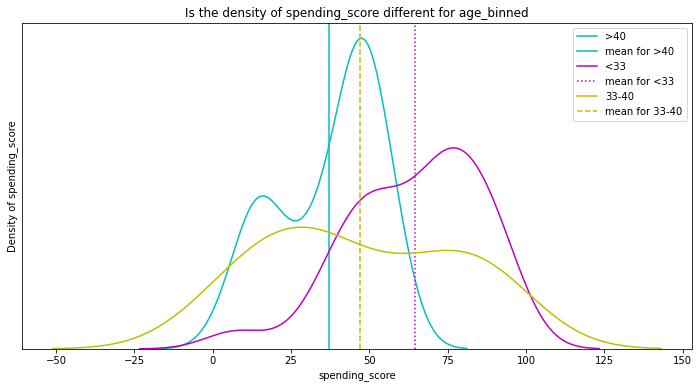

In [165]:

cat = "age_binned"
num = "spending_score"

alpha = .05
for cat_1 in train[cat].unique():
    for cat_2 in train[cat].unique():
        if not train[cat].unique().tolist().index(cat_2) >= train[cat].unique().tolist().index(cat_1):
            H0 = f"{num} of {cat}{cat_1} has identical average values to {num} of other {cat}{cat_2}"
            Ha = f"{num} of {cat} is not equal to {num} of other {cat}"
            print("-----------------------------")
            #compare variances to know how to run the test
            stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
            stat,pval
            if pval > 0.05:
                equal_var_flag = True
                print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
            else:
                equal_var_flag = False
                print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))
            t, p = stats.ttest_ind( train[train[cat] == cat_1][num], train[train[cat] == cat_2][num], equal_var = equal_var_flag )
            if p > alpha:
                print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
            else:
                print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))
plt.figure(figsize=(12,6))
plt.title(f"Is the density of {num} different for {cat}")
plt.ylabel(f"Density of {num}")
plt.yticks([],[])
colorlist=['c', 'm', 'y', 'k']
linestyle_list = ['solid', 'dotted','dashed','dashdot']
for i in enumerate(train[cat].unique()):
    sns.kdeplot(train[train[cat] == i[1]][num],
                label=f"{i[1]}",
                color=colorlist[i[0]])
    plt.axvline(train[train[cat] == i[1]][num].mean(),
                color=colorlist[i[0]],
                ls=linestyle_list[i[0]],
                label=f"mean for {i[1]}")
plt.xlabel(f"{num}")
plt.legend()
plt.show()

-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=107.93346, p=0.00000

 We fail to reject the null hypothesis ( spending_score of income_binned<40 has identical average values to spending_score of other income_binned40-66 ) t=0.28378, p=0.77844
-----------------------------
we can reject that there are equal variance in these two groups with 1.0 certainty Flag=F stat=139.95195, p=0.00000

 We fail to reject the null hypothesis ( spending_score of income_binned>66 has identical average values to spending_score of other income_binned40-66 ) t=0.36119, p=0.71951
-----------------------------
we can accept that there are equal variance in these two groups with 0.45 certainty Flag=T stat=0.58664, p=0.44609

 We fail to reject the null hypothesis ( spending_score of income_binned>66 has identical average values to spending_score of other income_binned<40 ) t=0.01942, p=0.98455


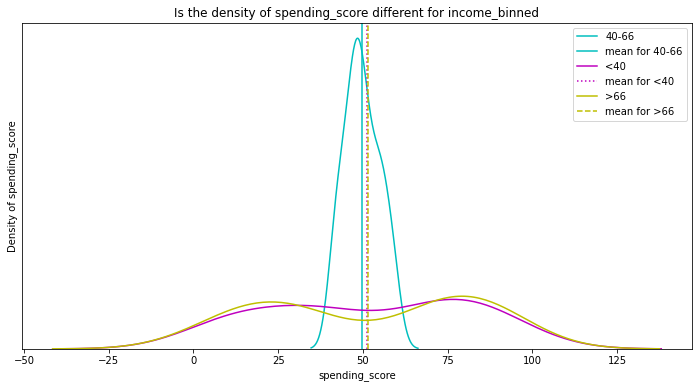

In [166]:

cat = "income_binned"
num = "spending_score"

alpha = .05
for cat_1 in train[cat].unique():
    for cat_2 in train[cat].unique():
        if not train[cat].unique().tolist().index(cat_2) >= train[cat].unique().tolist().index(cat_1):
            H0 = f"{num} of {cat}{cat_1} has identical average values to {num} of other {cat}{cat_2}"
            Ha = f"{num} of {cat} is not equal to {num} of other {cat}"
            print("-----------------------------")
            #compare variances to know how to run the test
            stat,pval = stats.levene(train[train[cat] == cat_1][num],train[train[cat] == cat_2][num])
            stat,pval
            if pval > 0.05:
                equal_var_flag = True
                print(f"we can accept that there are equal variance in these two groups with {round(pval,2)} certainty Flag=T",'stat=%.5f, p=%.5f' % (stat,pval))
            else:
                equal_var_flag = False
                print(f"we can reject that there are equal variance in these two groups with {round((1-pval),2)} certainty Flag=F",'stat=%.5f, p=%.5f' % (stat,pval))
            t, p = stats.ttest_ind( train[train[cat] == cat_1][num], train[train[cat] == cat_2][num], equal_var = equal_var_flag )
            if p > alpha:
                print("\n We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
            else:
                print("\n We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))
plt.figure(figsize=(12,6))
plt.title(f"Is the density of {num} different for {cat}")
plt.ylabel(f"Density of {num}")
plt.yticks([],[])
colorlist=['c', 'm', 'y', 'k']
linestyle_list = ['solid', 'dotted','dashed','dashdot']
for i in enumerate(train[cat].unique()):
    sns.kdeplot(train[train[cat] == i[1]][num],
                label=f"{i[1]}",
                color=colorlist[i[0]])
    plt.axvline(train[train[cat] == i[1]][num].mean(),
                color=colorlist[i[0]],
                ls=linestyle_list[i[0]],
                label=f"mean for {i[1]}")
plt.xlabel(f"{num}")
plt.legend()
plt.show()

In [167]:
temp1 = train.drop(columns=["age","annual_income"]).groupby(["Male","age_binned","income_binned"]).agg(["count","min","max"]).reset_index()
temp1["range"] = temp1["spending_score"]["max"] - temp1["spending_score"]["min"]
temp1 = temp1.dropna()
temp1

Male age_binned income_binned spending_score         range
                                          count min max      
0     0        <33           <40             12  42  94    52
1     0        <33         40-66              9  42  57    15
2     0        <33           >66             14  29  95    66
3     0      33-40           <40              3   6  35    29
4     0      33-40         40-66              1  42  42     0
5     0      33-40           >66              6  22  91    69
6     0        >40           <40              6   5  35    30
7     0        >40         40-66             15  42  59    17
8     0        >40           >66              8   7  43    36
9     1        <33           <40              7  39  92    53
10    1        <33         40-66              4  49  59    10
11    1        <33           >66              8   5  83    78
12    1      33-40           <40              1  13  13     0
13    1      33-40         40-66              1  48  48     0
14    1      33-40           >66              5   1  91    90
15    1        >40           <40              2  14  36    22
16    1        >40         40-66             12  42  59    17
17    1        >40           >66              6   9  36    27

In [171]:
from sklearn.cluster import KMeans

In [175]:
train_scaled = X_train_scaled.copy()
train["spending_score"]

In [176]:
train

,age,annual_income,spending_score,Male,age_binned,income_binned
customer_id,,,,,,
64,54,47,59,0,>40,40-66
49,29,40,42,0,<33,<40
25,54,28,14,0,>40,<40
137,44,73,7,0,>40,>66
177,58,88,15,1,>40,>66
...,...,...,...,...,...,...
176,30,88,86,0,<33,>66
102,49,62,48,0,>40,40-66
149,34,78,22,0,33-40,>66


In [174]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X_train_scaled)
kmeans.fit(train_scaled)
train["cluster"] = kmeans.predict(train_scaled)

,age,annual_income
64,0.692308,0.262295
49,0.211538,0.204918
25,0.692308,0.106557
137,0.500000,0.475410
177,0.769231,0.598361
...,...,...
176,0.230769,0.598361
102,0.596154,0.385246
149,0.307692,0.516393
100,0.038462,0.377049
